# Import

In [1]:
import sys
sys.path.append("..")

from src.data import CrossSimilarityDataset
from src.utils import plot_cross_similarity
from src.transforms import RandomJumps
from src.asap import load_annotations, ASAPWrapper
from src.dcnn import DCNN
from src.trainer import Trainer

import os
from tqdm import tqdm

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Resize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

warnings.simplefilter('ignore')

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load dataset

In [4]:
# Path to the clonned ASAP repository

asap_dir = "../../asap-dataset"

In [5]:
asap_wrapper = ASAPWrapper(asap_dir, val_ratio=0.2, random_seed=42)

In [6]:
print(f'Number of performances in train: {len(asap_wrapper.train_paths)}')
print(f'Number of performances in val: {len(asap_wrapper.val_paths)}')

Number of performances in train: 827
Number of performances in val: 209


In [14]:
img_size = 256
fs = 10 # Sampling frequency
transform = Resize((img_size, img_size))
min_num_jumps = 1
max_num_jumps = 1
jumps_transform = RandomJumps(fs, min_num_jumps=min_num_jumps, max_num_jumps=max_num_jumps, max_silence_s=8.)

train_dataset = CrossSimilarityDataset(asap_wrapper.train_paths,
                                       fs,
                                       transform,
                                       structural_transform=jumps_transform,
                                       inference_only=False)

val_dataset = CrossSimilarityDataset(asap_wrapper.val_paths,
                                     fs,
                                     transform,
                                     structural_transform=jumps_transform,
                                     inference_only=False)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

torch.Size([32, 1, 256, 256])
torch.Size([32, 2, 2])


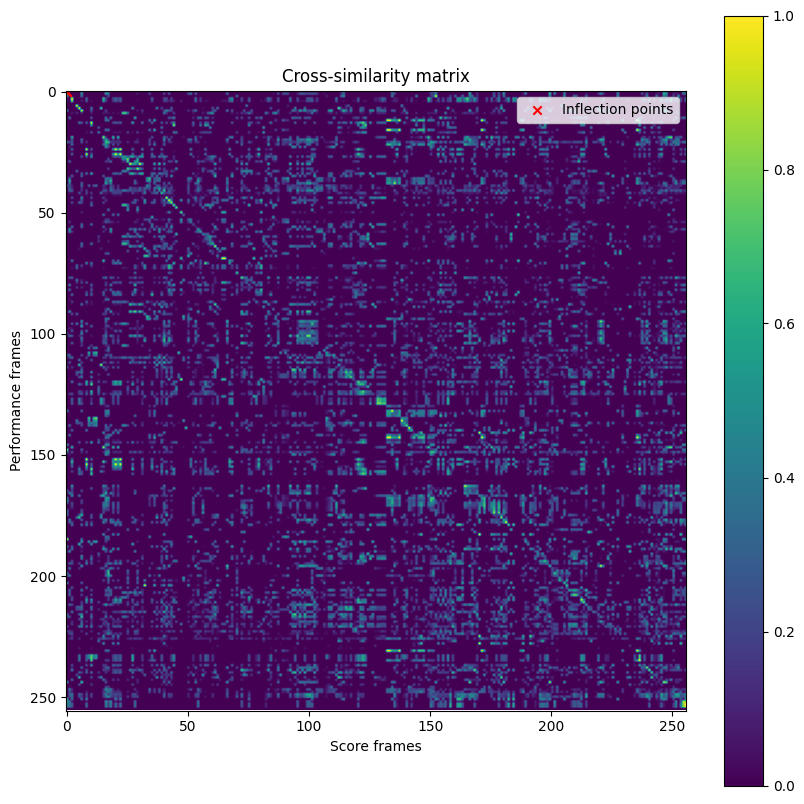

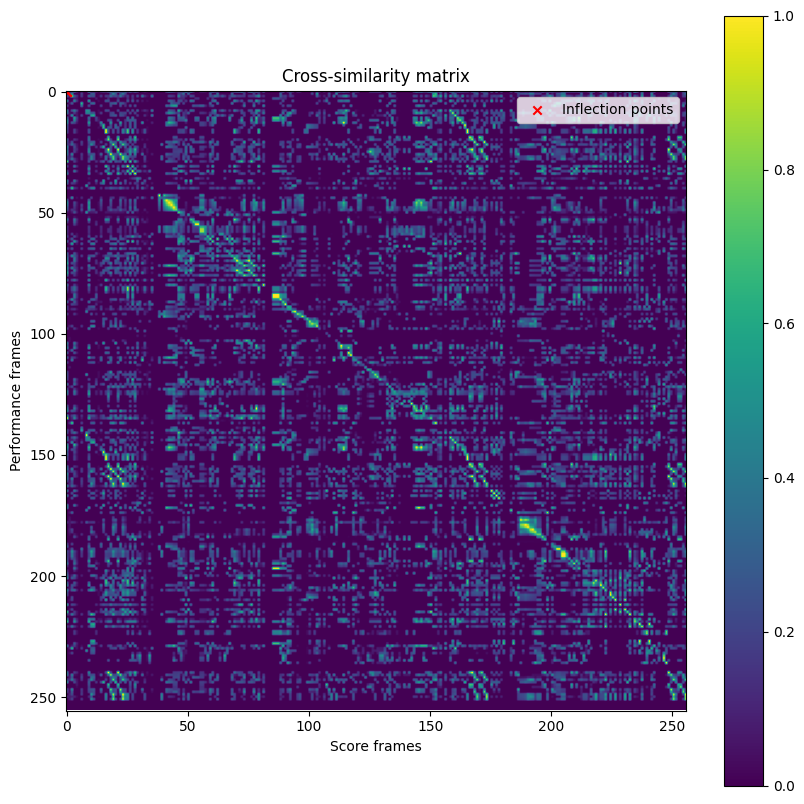

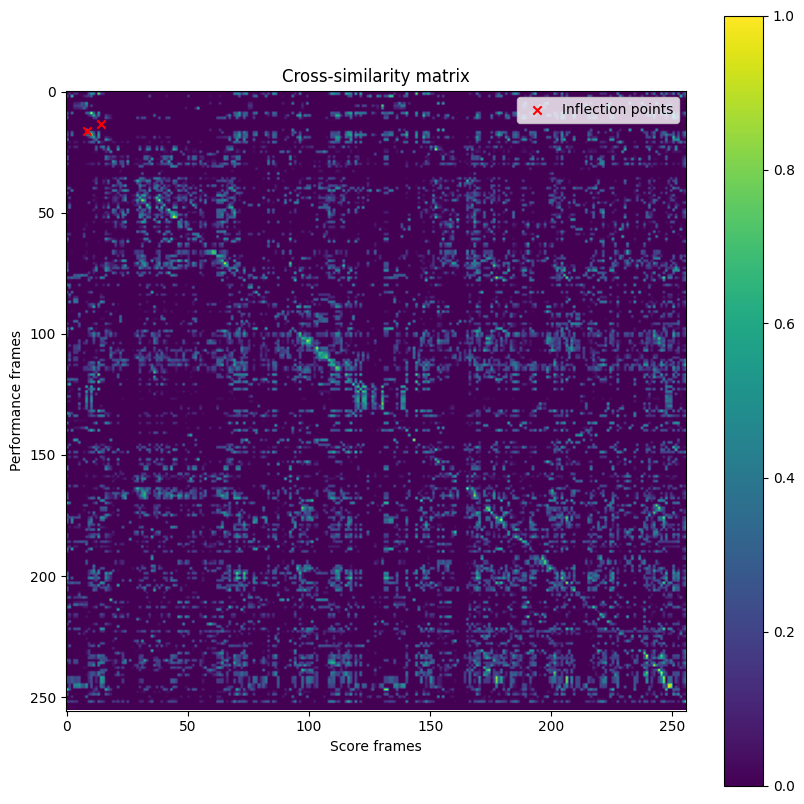

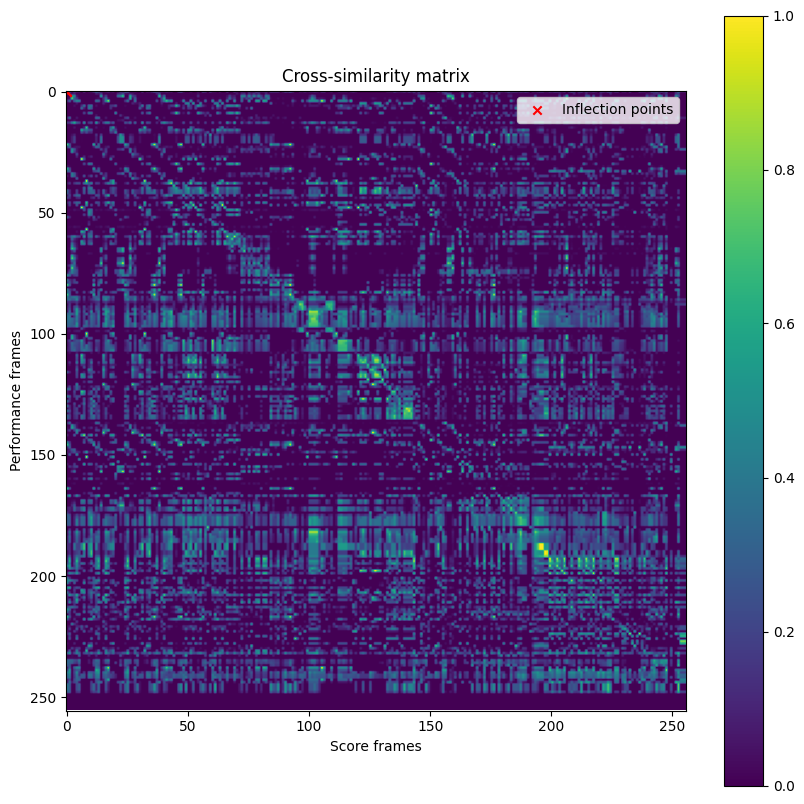

In [16]:
for batch in train_loader:
    x = batch['image']
    target = batch['target']
    for i in range(4):
        plot_cross_similarity(x[i],
                              beat_alignment=None,
                              inflection_points=target[i])
    print(x.shape)
    print(target.shape)
    break

# Model

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
model = DCNN(img_size, [2, 4, 8], max_num_jumps * 2).to(device)

In [19]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

num_epochs = 10

In [20]:
trainer = Trainer(train_loader,
                  val_loader,
                  num_epochs,
                  optimizer,
                  device)

In [21]:
trainer.train(model)

100%|██████████| 26/26 [02:08<00:00,  4.96s/it]


Epoch: 0, Train loss: 88.06875376403332


100%|██████████| 7/7 [00:37<00:00,  5.37s/it]


Epoch: 0, Val loss: 0.5747420601546764


100%|██████████| 26/26 [01:59<00:00,  4.61s/it]


Epoch: 1, Train loss: 2.6304455548524857


100%|██████████| 7/7 [00:37<00:00,  5.37s/it]


Epoch: 1, Val loss: 0.7635155413299799


100%|██████████| 26/26 [02:05<00:00,  4.84s/it]


Epoch: 2, Train loss: 2.422343635931611


100%|██████████| 7/7 [00:38<00:00,  5.49s/it]


Epoch: 2, Val loss: 0.6043950170278549


100%|██████████| 26/26 [02:14<00:00,  5.19s/it]


Epoch: 3, Train loss: 2.74049574136734


100%|██████████| 7/7 [00:38<00:00,  5.44s/it]


Epoch: 3, Val loss: 0.6078969389200211


100%|██████████| 26/26 [02:11<00:00,  5.06s/it]


Epoch: 4, Train loss: 2.5076022893190384


100%|██████████| 7/7 [00:38<00:00,  5.43s/it]


Epoch: 4, Val loss: 0.6734214201569557


100%|██████████| 26/26 [02:12<00:00,  5.10s/it]


Epoch: 5, Train loss: 2.325427617877722


100%|██████████| 7/7 [00:38<00:00,  5.56s/it]


Epoch: 5, Val loss: 0.5786649435758591


100%|██████████| 26/26 [02:03<00:00,  4.75s/it]


Epoch: 6, Train loss: 2.2239775732159615


100%|██████████| 7/7 [00:37<00:00,  5.38s/it]


Epoch: 6, Val loss: 0.7115429639816284


100%|██████████| 26/26 [02:08<00:00,  4.96s/it]


Epoch: 7, Train loss: 2.2469193674623966


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


Epoch: 7, Val loss: 0.696105781942606


100%|██████████| 26/26 [02:10<00:00,  5.04s/it]


Epoch: 8, Train loss: 2.05657109990716


100%|██████████| 7/7 [00:39<00:00,  5.59s/it]


Epoch: 8, Val loss: 0.6455283798277378


100%|██████████| 26/26 [02:08<00:00,  4.95s/it]


Epoch: 9, Train loss: 2.0629491433501244


100%|██████████| 7/7 [00:37<00:00,  5.38s/it]

Epoch: 9, Val loss: 0.6093795448541641


torch.Size([32, 1, 256, 256])
torch.Size([32, 2, 2])


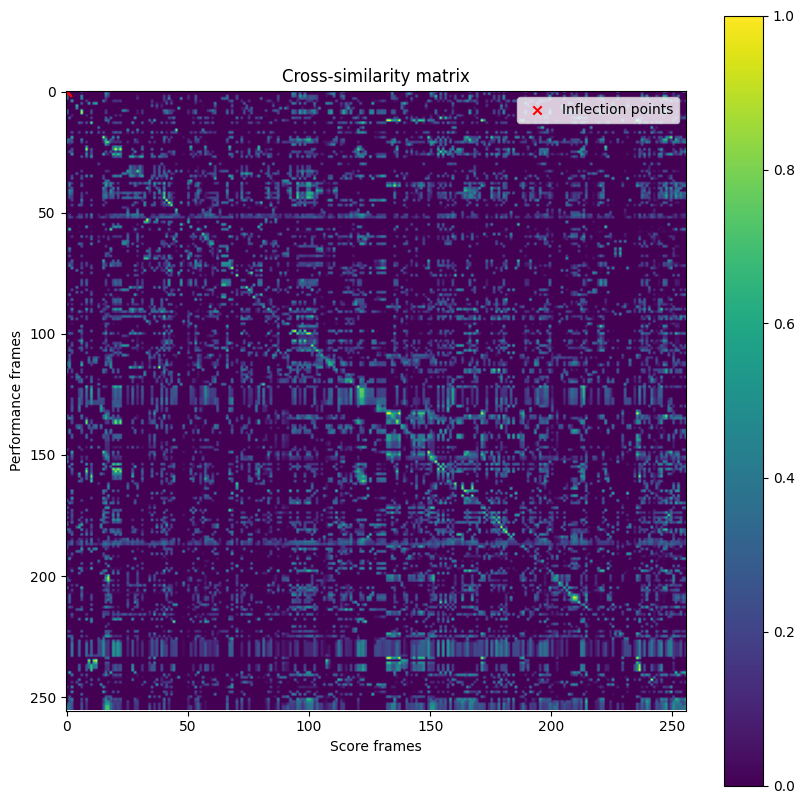

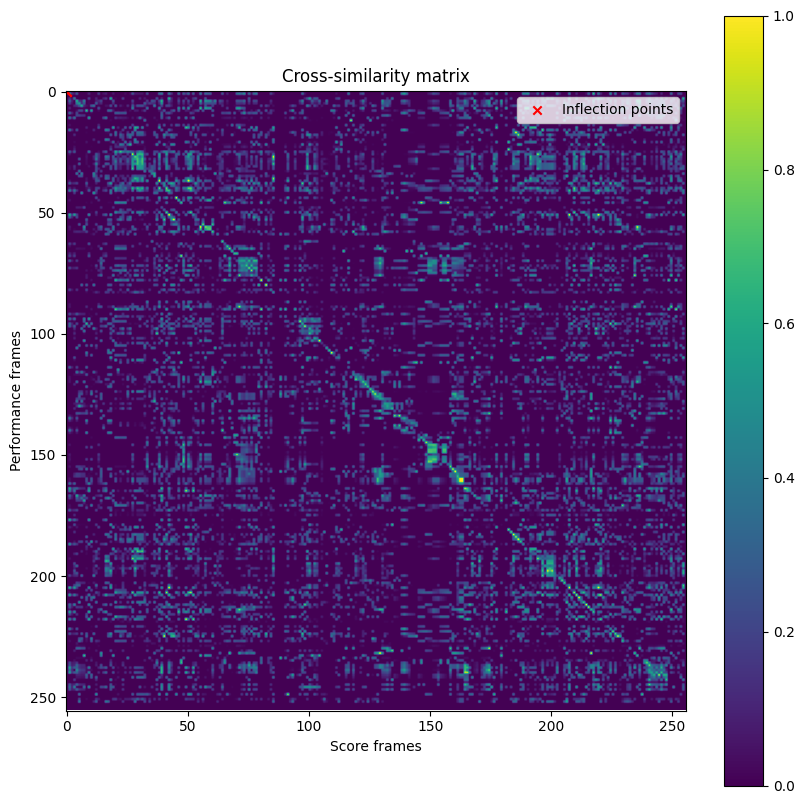

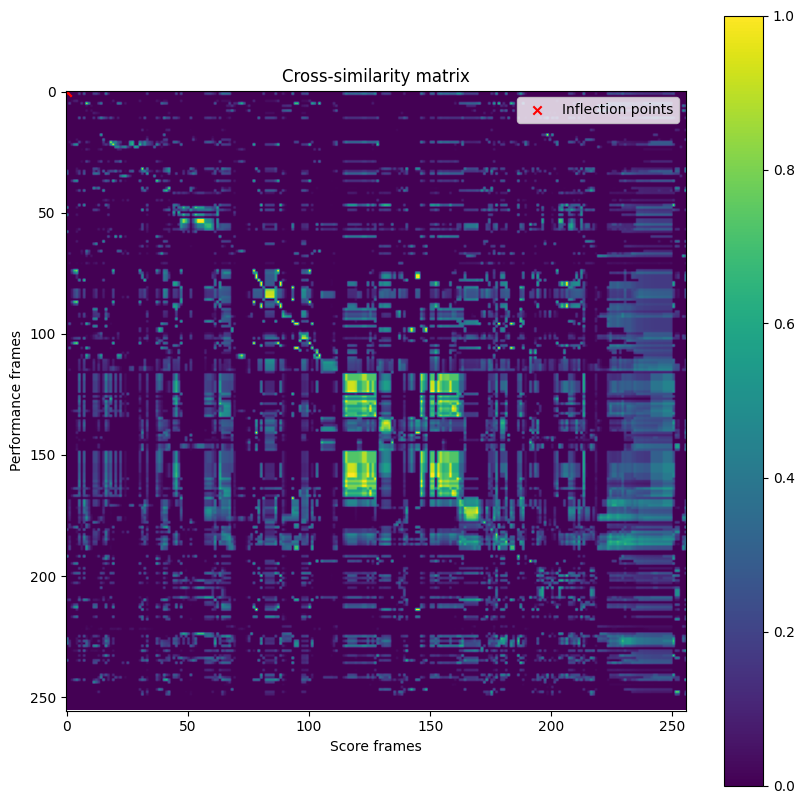

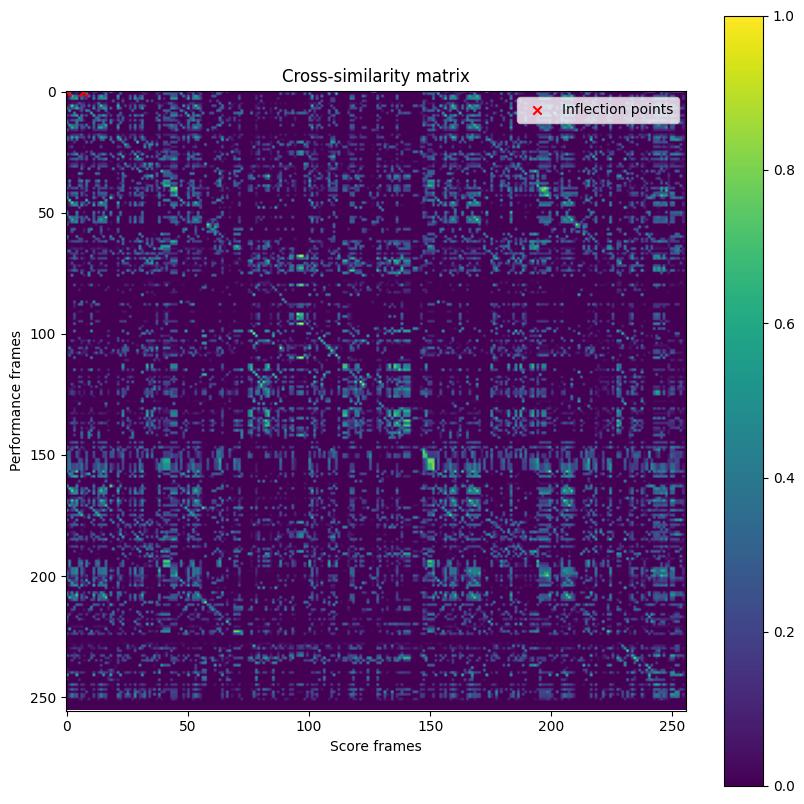

In [22]:
for batch in train_loader:
    x = batch['image'].to(device)
    y_true = batch['target'].to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(x).cpu()
    x = x.cpu()
    for i in range(4):
        plot_cross_similarity(x[i],
                              beat_alignment=None,
                              inflection_points=y_pred[i])
    print(x.shape)
    print(target.shape)
    break

In [23]:
y_pred

tensor([[[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 2.6626e-02],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 5.2807e-01],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 2.6171e-02],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 5.5288e-01],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 8.3906e-01],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 4.1305e-01],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 4.2160e-03],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 5.6127e-01],
         [0.0000e+00, 0.0000e